# MOVIE STUDIO ANALYSIS

## Business Understanding

## Overview 

In this project, we are tackling a critical business challenge for my company as we venture into the competitive world of original video content creation. Recognizing the trend of major companies producing their own content, our leadership has decided to establish a new movie studio. However, we face a significant knowledge gap in the film industry.

Our role is to conduct a comprehensive analysis of the current box office landscape to identify which types of films are performing best. This research is crucial as it will form the foundation of our studio's content strategy. We are tasked with analyzing data and translating our findings into actionable insights.

## Objective 

The ultimate goal of this project is to provide our newly appointed head of the movie studio with data-driven recommendations. These insights will be instrumental in guiding decisions about which types of films to produce, helping us to strategically position our new studio in the market and maximize our chances of box office success.

### Data Understanding


We will be using the following datasets;

1.`rt.reviews.tsv` from [Rotten Tomatoes](https://www.rottentomatoes.com)

2.`im.db` from [IMDB](https://www.imdb.com/)

3.`tn.movie_budgets` from [The NUMBERS](https://www.the-numbers.com/)

4.`rt.movie_info.tsv` from [Rotten Tomatoes](https://www.rottentomatoes.com)

The dataset consists of multiple sources providing various perspectives on movies. The `review_df` captures movie reviews with columns such as id, review, rating, fresh, critic, top_critic, publisher, and date. This data includes reviewer comments, ratings, and the nature of the review (fresh or rotten), along with details about the critic and publication date, enabling analysis of review trends and critic influence.

The `movie_info_df` provides detailed movie information, including id, synopsis, rating (target audience), genre, director, writer, theatre date, dvd date, currency, box office, runtime, and studio. This data allows for examination of movie content, production details, and performance, with information on plot summaries, target audiences, genres, key personnel, release dates, and box office revenues.

The `movie_budgets_df` datasets offer financial insights. `Movie_budgets_df` contains id, release date, movie, production_budget, domestic gross, and worldwide gross, providing data on production costs and revenue. Additionally, the `im.db_df` from a SQL database includes structured movie attributes and ratings. Together, these datasets facilitate a comprehensive analysis of movie performance, financial success, and audience reception.

##### Importing libraries

In [1]:

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

# Suppress harmless warnings for use_inf_as_na
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
            
# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

##### Loading Datasets

In [2]:

file_path = 'data/rt.reviews.tsv'

try:
  reviews_df = pd.read_csv(file_path, sep='\t',on_bad_lines='skip',encoding='ISO-8859-1')
except pd.errors.ParserError as e:
    print(f'Error parsing file:{e}')
reviews_df


,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [3]:
conn = sqlite3.connect('data/im.db')
q = """SELECT *
FROM movie_basics
JOIN movie_ratings
USING(movie_id)"""
imdb_df = pd.read_sql(q,conn)
imdb_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [4]:
# Closing the database connection
conn.close()

In [5]:
path = 'data/tn.movie_budgets.csv'
movie_budgets_df = pd.read_csv(path)

In [6]:
path = 'data/rt.movie_info.tsv'
try:
  movie_info_df = pd.read_csv(path, sep='\t',on_bad_lines='skip',encoding='ISO-8859-1')
except pd.errors.ParserError as e:
    print(f'Error parsing file:{e}')


## Data Cleaning

#### 1.Reviews_df and Movie_info df

In [7]:
# reviews_df
# using .info to understand the dataset
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [8]:
# movie_info_df
movie_info_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


#### Merging reviews_df and movie_info_df

We merge the two datasets using the `id` column since they are from the same source,`Rotten Tomatoes`

In [9]:

merged_df = pd.merge(reviews_df,movie_info_df,on='id',how='inner')


#### Dropping unnecessary columns

In [10]:
columns_to_drop =['review','critic','top_critic','publisher','synopsis','writer','studio','currency','box_office']
merged_df = merged_df.drop(columns_to_drop,axis=1)
merged_df.head()

,id,rating_x,fresh,date,rating_y,genre,director,theater_date,dvd_date,runtime
0,3,3/5,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
1,3,NaN,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
2,3,NaN,fresh,"January 4, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
3,3,NaN,fresh,"November 16, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
4,3,NaN,fresh,"October 12, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes


#### Changing column names for `rating_x` and `rating_y` to `star_rating` and `MPAA_rating` respectively to accurately reflect the columns after merging.

In [11]:
merged_df.rename(columns= {'rating_x': 'star_rating', 'rating_y': 'MPAA_rating'} , inplace=True)
merged_df.head()

,id,star_rating,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,runtime
0,3,3/5,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
1,3,NaN,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
2,3,NaN,fresh,"January 4, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
3,3,NaN,fresh,"November 16, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
4,3,NaN,fresh,"October 12, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes


#### Checking for null values for the merged dataset

In [12]:
merged_df.isna().sum()

id                  0
star_rating     13517
fresh               0
date                0
MPAA_rating        86
genre              87
director         5440
theater_date     1226
dvd_date         1226
runtime           838
dtype: int64

There are null values in seven columns which we will handle below.

In [13]:
#handling missing values in columns 'director','theatre_date', 'dvd_date','runtime'
# Drop rows with missing values in specific columns
merged_df.dropna(subset=['theater_date', 'dvd_date'], inplace=True)

# Fill with specific values
merged_df['director'].fillna('Unknown', inplace=True)



#### Standardizing star ratings by assigning them to a unique scale,0 - 10

In [14]:
# Function to convert star ratings to a 0-10 scale
def convert_rating(rating):
    if pd.isna(rating):
        return np.nan
    
    # Handle mixed fractions (e.g., '3 1/2')
    if ' ' in rating and '/' in rating:
        whole, frac = rating.split(' ')
        num, denom = frac.split('/')
        return (float(whole) + float(num) / float(denom)) * 10 / (10 / float(denom))
    
    # Convert fraction ratings (e.g., '3/5')
    if '/' in rating:
        num, denom = rating.split('/')
        num = float(num)
        denom = float(denom)
        return (num / denom) * 10
    
    # Convert letter grades
    letter_grades = {
        'A+': 10, 'A': 9.5, 'A-': 9,
        'B+': 8.5, 'B': 8, 'B-': 7.5,
        'C+': 7, 'C': 6.5, 'C-': 6,
        'D+': 5.5, 'D': 5, 'D-': 4.5,
        'F': 2.5, 'F+': 2, 'F-': 1.5
    }
    if rating in letter_grades:
        return letter_grades[rating]
    
    # Handle unconventional ratings ('N', 'R', etc.)
    unconventional_ratings = {
        'N': np.nan, 'R': np.nan  # Treat as missing values or set specific values
    }
    if rating in unconventional_ratings:
        return unconventional_ratings[rating]
    
    # Convert direct numeric ratings if within the range
    try:
        value = float(rating)
        if 0 <= value <= 10:
            return value
    except ValueError:
        pass
    
    return np.nan

# Apply conversion function to the star_rating column
merged_df['standardized_rating'] = merged_df['star_rating'].apply(convert_rating)



We calculate the mean of the standardized rating

In [15]:
mean_std_rating = merged_df['standardized_rating'].mean()
mean_std_rating

6.387381892716092

In [16]:
merged_df['standardized_rating'].isna().sum()

13200

Filling the null values with the mean of the standardized rating calculated above.

In [17]:
merged_df['standardized_rating'].fillna(merged_df['standardized_rating'].mean(), inplace=True)
print(merged_df['standardized_rating'].mean())

6.3873818927160935


In [19]:
#dropping rows with missing values on column names 'MPAA_rating' and 'genre'
merged_df=merged_df.dropna(subset=['MPAA_rating','genre'])

In [20]:
#drop 'star_rating' column since we now have a 'standardized rating' column.
merged_df.drop('star_rating', axis=1, inplace=True)

In [19]:
merged_df.isna().sum()

id                       0
fresh                    0
date                     0
MPAA_rating              0
genre                    0
director                 0
theater_date             0
dvd_date                 0
runtime                736
standardized_rating      0
dtype: int64

#### Checking for duplicates in our merged dataset and dropping the duplicates.

In [21]:
#checking duplicates
duplicated_rows = merged_df[merged_df.duplicated()]
#dropping duplicates
merged_df=merged_df.drop_duplicates()


In [22]:
merged_df.isna().sum()

id                       0
fresh                    0
date                     0
MPAA_rating              0
genre                    0
director                 0
theater_date             0
dvd_date                 0
runtime                457
standardized_rating      0
dtype: int64

We still have null values in the run time column which we will handle below by imputing the null values with the mean of the runtime.

In [23]:
merged_df['runtime'].unique()

array(['108 minutes', '116 minutes', '128 minutes', '95 minutes',
       '82 minutes', '123 minutes', '117 minutes', '90 minutes',
       '97 minutes', '106 minutes', '129 minutes', '98 minutes',
       '127 minutes', '96 minutes', '114 minutes', '110 minutes',
       '91 minutes', '103 minutes', '142 minutes', '119 minutes',
       '122 minutes', '86 minutes', '93 minutes', '111 minutes',
       '89 minutes', '115 minutes', '107 minutes', '165 minutes',
       '99 minutes', '113 minutes', '92 minutes', '102 minutes',
       '135 minutes', '101 minutes', '109 minutes', '124 minutes',
       '104 minutes', '105 minutes', '100 minutes', '134 minutes',
       '87 minutes', '167 minutes', '188 minutes', '126 minutes',
       '63 minutes', '132 minutes', '137 minutes', '79 minutes',
       '65 minutes', '156 minutes', '147 minutes', '171 minutes',
       '59 minutes', '80 minutes', '94 minutes', '118 minutes',
       '88 minutes', '81 minutes', '85 minutes', '143 minutes',
       '133 minut

In [24]:
#handling null values on run time column
#filling the null values with the mean.
#extracting the word 'minutes' so our values can be in float format.
merged_df['runtime'] = merged_df['runtime'].str.replace(' minutes', '').astype(float)
mean_runtime = merged_df['runtime'].mean()
merged_df['runtime'].fillna(mean_runtime,inplace=True)

In [25]:
merged_df.isna().sum()

id                     0
fresh                  0
date                   0
MPAA_rating            0
genre                  0
director               0
theater_date           0
dvd_date               0
runtime                0
standardized_rating    0
dtype: int64

We checked for null values in our columns and we now have a dataset with no null values.

#### 2.Movie_budgets_df

#### Checking for data types in our dataset

In [25]:
#checking for data types
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


#### Conversion and standardizing our `release_date` column and `production_budget`,`domestic_gross`,`worldwide_gross` columns

In [26]:
#conversion
# Convert 'release_date' to datetime
movie_budgets_df['release_date'] = pd.to_datetime(movie_budgets_df['release_date'])

# Function to remove dollar signs and commas and convert to numeric
def clean_currency(column):
    return column.replace('[\$,]', '', regex=True).astype(float)

# Apply the function to the budget and gross columns
movie_budgets_df['production_budget'] = clean_currency(movie_budgets_df['production_budget'])
movie_budgets_df['domestic_gross'] = clean_currency(movie_budgets_df['domestic_gross'])
movie_budgets_df['worldwide_gross'] = clean_currency(movie_budgets_df['worldwide_gross'])


#### Checking for null values in our dataset

In [28]:
#checking for null values
movie_budgets_df.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

No null values found in the dataset

#### Checking for duplicates in our dataset

In [29]:
#checking for duplicates
duplicated_rows = movie_budgets_df[movie_budgets_df.duplicated()]
duplicated_rows

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross


No duplicates found in the dataset

#### 3.imdb_df

#### Checking for duplicates in the dataset

In [30]:
#checking for duplicates
duplicated_rows = imdb_df[imdb_df.duplicated()]
duplicated_rows

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes


No duplicates found in the dataset

#### Checking for null values in the dataset

In [30]:
#checking for null values
imdb_df.isna().sum()

movie_id              0
primary_title         0
original_title        0
start_year            0
runtime_minutes    7620
genres              804
averagerating         0
numvotes              0
dtype: int64

We have null values in the runtime_minutes and genres columns which we will handle below by dropping the null values in the two columns as they consistute a small portion our data.

In [32]:
#drop null values on columns 'runtime' and 'genre'
imdb_df = imdb_df.dropna(subset=['runtime_minutes','genres'])

In [33]:
#Confirming if the null values have been handled.
imdb_df.isna().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
averagerating      0
numvotes           0
dtype: int64

In [34]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65720 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         65720 non-null  object 
 1   primary_title    65720 non-null  object 
 2   original_title   65720 non-null  object 
 3   start_year       65720 non-null  int64  
 4   runtime_minutes  65720 non-null  float64
 5   genres           65720 non-null  object 
 6   averagerating    65720 non-null  float64
 7   numvotes         65720 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


## Exploratory Data Analysis & Visualization

### Univariate Data Analysis

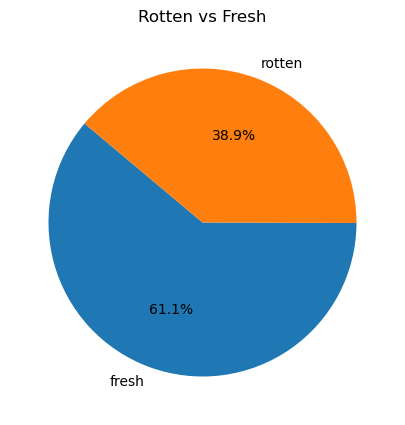

In [34]:
frequencies = merged_df['fresh'].value_counts()
plt.figure(figsize=(8, 5))
plt.pie(frequencies, labels=frequencies.index, autopct='%1.1f%%', startangle=140)
plt.title('Rotten vs Fresh')
plt.show()

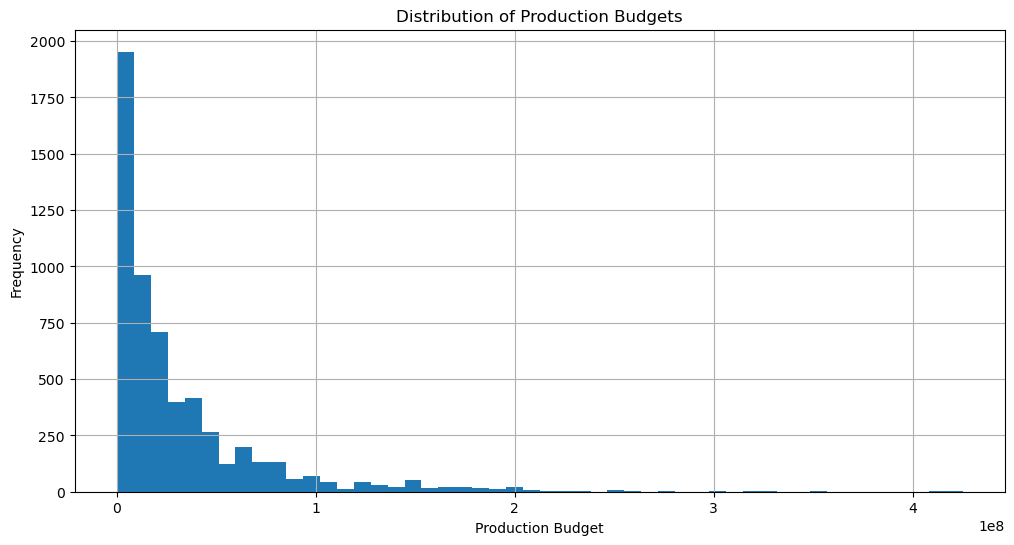

In [35]:
# distribution of production budget
plt.figure(figsize=(12, 6))
movie_budgets_df['production_budget'].hist(bins=50)
plt.xlabel('Production Budget')
plt.ylabel('Frequency')
plt.title('Distribution of Production Budgets')
plt.show()

#### IMDB Analysis

In [38]:
# Normalize genre strings
imdb_df['genres'] = imdb_df['genres'].str.strip().str.lower()

# Tokenize genres
imdb_df['genres_list'] = imdb_df['genres'].str.split(',')

# Expand genres into separate columns
genres_expanded = imdb_df['genres_list'].explode().unique()
for genre in genres_expanded:
    imdb_df[genre] = imdb_df['genres_list'].apply(lambda x: 1 if genre in x else 0)

# Drop the intermediate columns
df = imdb_df.drop(columns=['genres', 'genres_list'])

df

,movie_id,primary_title,original_title,start_year,runtime_minutes,averagerating,numvotes,action,crime,drama,...,war,music,sport,western,musical,news,reality-tv,game-show,adult,short
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,7.0,77,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,7.2,43,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,6.9,4517,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,6.5,119,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,8.1,263,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73849,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,130.0,8.4,365,0,0,1,...,0,0,0,0,0,0,0,0,0,0
73850,tt9913056,Swarm Season,Swarm Season,2019,86.0,6.2,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,6.2,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,8.7,136,0,0,1,...,0,0,0,0,0,0,0,0,0,0


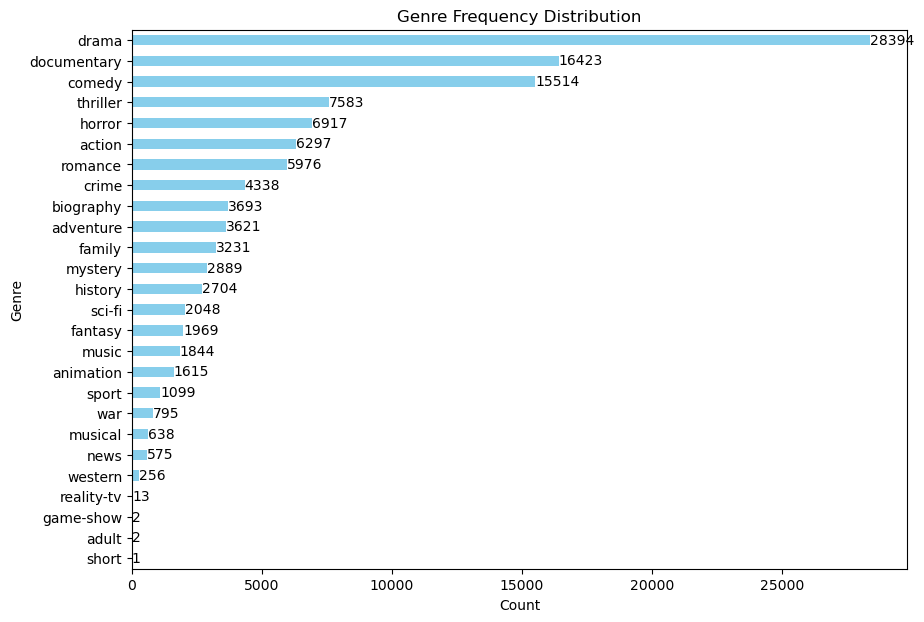

In [39]:
#Frequency count

# Count the frequency of each genre
genre_counts = df[genres_expanded].sum()

# Plot the distribution
plt.figure(figsize=(10, 7))
ax = genre_counts.sort_values().plot(kind='barh', color='skyblue')

# Add count labels next to each bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.1, p.get_y() + p.get_height() / 2, int(width), 
            ha='left', va='center', color='black')

plt.title('Genre Frequency Distribution')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

### Genre Combinations
Analyze how different genres frequently appear together. You can use pairwise counts to see which genres often co-occur.

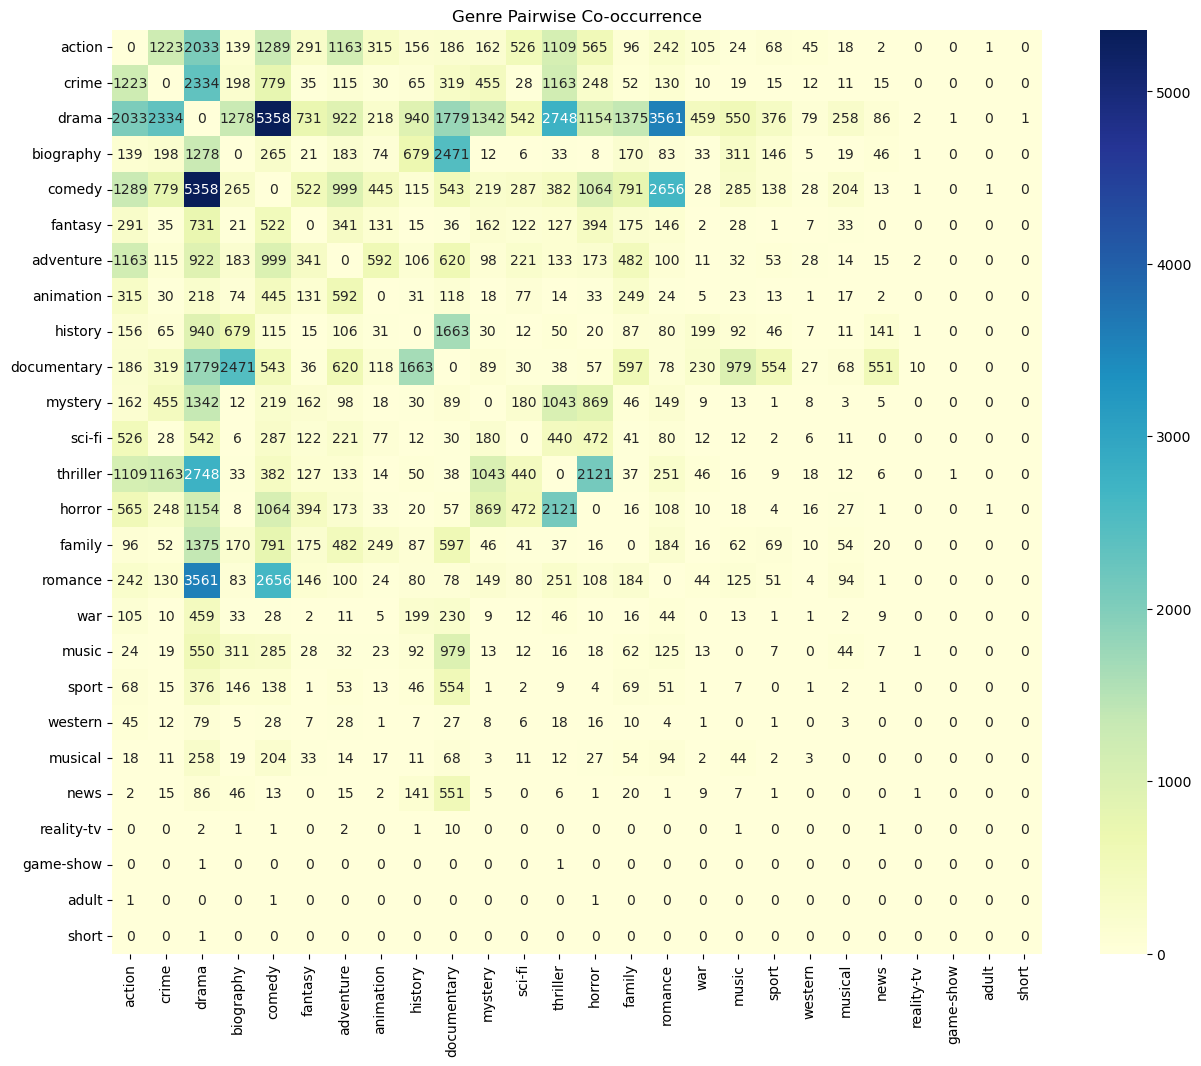

In [38]:
# Create a DataFrame for pairwise genre combinations
from itertools import combinations

# Calculate pairwise genre co-occurrence
genre_pairs = pd.DataFrame(
    index=genres_expanded,
    columns=genres_expanded,
    data=0
)

for genre1, genre2 in combinations(genres_expanded, 2):
    genre_pairs.loc[genre1, genre2] = ((df[genre1] & df[genre2]).sum())
    genre_pairs.loc[genre2, genre1] = genre_pairs.loc[genre1, genre2]

# Plot the pairwise co-occurrence
plt.figure(figsize=(15, 12))
import seaborn as sns
sns.heatmap(genre_pairs, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Genre Pairwise Co-occurrence')
plt.show()

In [39]:
# Normalize genre strings
imdb_df['genres'] = imdb_df['genres'].str.strip().str.lower()

# Tokenize genres
imdb_df['genres_list'] = imdb_df['genres'].str.split(',')

# Create a DataFrame to store genre combinations
genre_combinations = pd.DataFrame(columns=['Combination', 'Count'])

# Generate genre combinations for each movie and count occurrences
combination_counts = {}

for _, row in imdb_df.iterrows():
    genres = sorted(row['genres_list'])  # Sort genres to ensure order consistency
    for r in range(1, len(genres) + 1):
        for combo in combinations(genres, r):
            combo_str = ' & '.join(combo)
            if combo_str in combination_counts:
                combination_counts[combo_str] += 1
            else:
                combination_counts[combo_str] = 1

# Convert the combination counts dictionary to a DataFrame
genre_combinations = pd.DataFrame(list(combination_counts.items()), columns=['Combination', 'Count'])

# Sort by Count in descending order
result_table = genre_combinations.sort_values(by='Count', ascending=False)

# Print the sorted table
print("Genre Combination Counts:")
print(result_table)

Genre Combination Counts:
                          Combination  Count
2                               drama  28394
22                        documentary  16423
9                              comedy  15514
36                           thriller   7583
40                             horror   6917
..                                ...    ...
798             drama & war & western      1
800        adventure & music & sci-fi      1
802        biography & family & sport      1
804  action & animation & documentary      1
966     documentary & family & sci-fi      1

[967 rows x 2 columns]


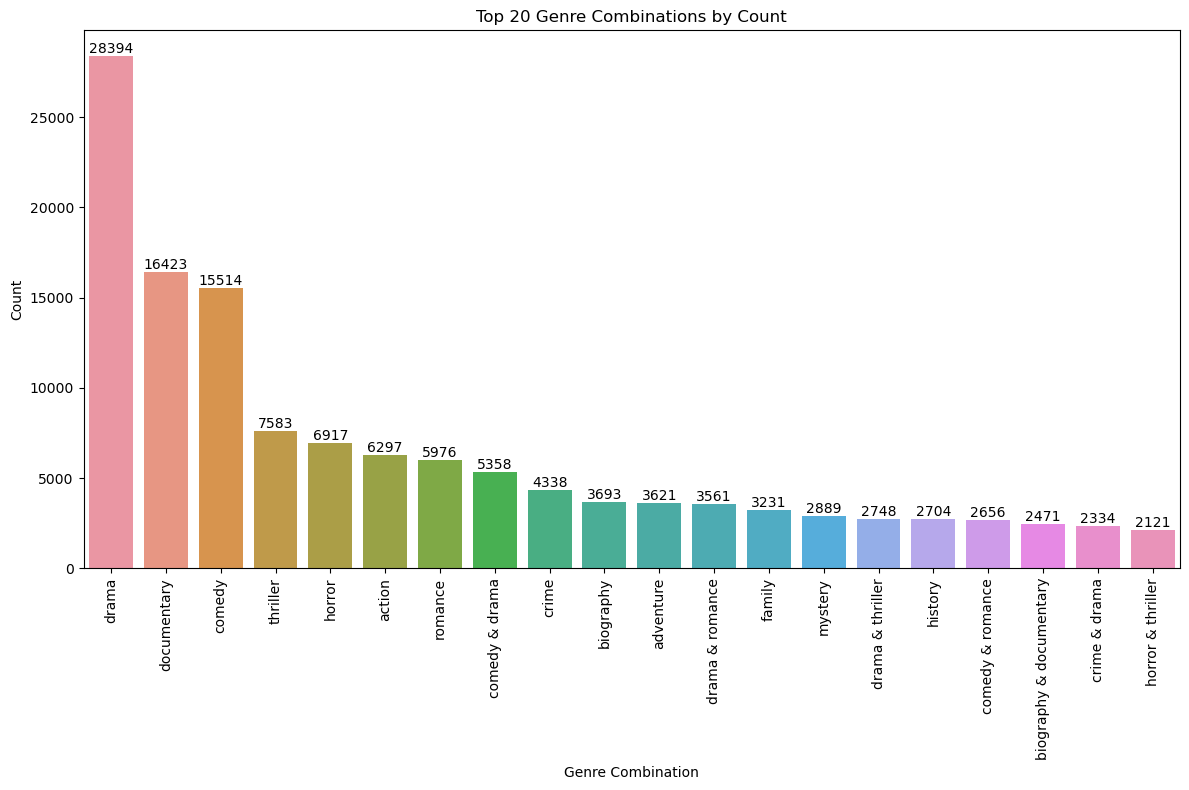

In [40]:
# Create DataFrame and select top 20 rows
result = pd.DataFrame(result_table)
result = result.head(20)

# Plotting the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=result['Combination'], y=result['Count'])

# Adding annotations (count values) on top of each bar
for index, value in enumerate(result['Count']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.title('Top 20 Genre Combinations by Count')
plt.xlabel('Genre Combination')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Movie_budgets_df analysis

In [43]:
#Top movies vs worldwide gross
top_grossing = movie_budgets_df.sort_values('worldwide_gross', ascending=False).head(10)
top_grossing[['movie', 'worldwide_gross']]

,movie,worldwide_gross
0,Avatar,2.776345e+09
42,Titanic,2.208208e+09
5,Star Wars Ep. VII: The Force Awakens,2.053311e+09
6,Avengers: Infinity War,2.048134e+09
33,Jurassic World,1.648855e+09
66,Furious 7,1.518723e+09
26,The Avengers,1.517936e+09
3,Avengers: Age of Ultron,1.403014e+09
41,Black Panther,1.348258e+09
260,Harry Potter and the Deathly Hallows: Part II,1.341693e+09


In [44]:
#Return on investment
movie_budgets_df['ROI'] = (movie_budgets_df['worldwide_gross'] - movie_budgets_df['production_budget']) / movie_budgets_df['production_budget']
top_roi = movie_budgets_df.sort_values('ROI', ascending=False).head(10)
print(top_roi[['movie', 'ROI']])

                         movie          ROI
5745               Deep Throat  1799.000000
5613                   Mad Max   497.750000
5492       Paranormal Activity   430.517853
5679               The Gallows   415.564740
5406   The Blair Witch Project   412.833333
5709             Super Size Me   341.058585
5346                     Bambi   311.354312
5773               El Mariachi   290.704000
5676  Night of the Living Dead   262.921614
5210                     Rocky   224.000000


In [45]:
# Average budget and gross by year

# Function to clean currency and handle potential errors
def clean_currency(x):
    if isinstance(x, str):
        try:
            return float(x.replace('$', '').replace(',', ''))
        except ValueError:
            return np.nan
    return x if pd.notnull(x) else np.nan

# Clean the monetary columns
columns_to_clean = ['production_budget', 'domestic_gross', 'worldwide_gross']
for col in columns_to_clean:
    movie_budgets_df[col] = movie_budgets_df[col].apply(clean_currency)
    movie_budgets_df[col] = pd.to_numeric(movie_budgets_df[col], errors='coerce')

# Convert release_date to datetime and extract the year
movie_budgets_df['year'] = pd.to_datetime(movie_budgets_df['release_date'], errors='coerce').dt.year

# Calculate yearly averages
yearly_avg = movie_budgets_df.groupby('year')[columns_to_clean].mean()
print(yearly_avg)

      production_budget  domestic_gross  worldwide_gross
year                                                    
1915       1.100000e+05    1.000000e+07     1.100000e+07
1916       2.929535e+05    4.000000e+06     4.000000e+06
1920       1.000000e+05    3.000000e+06     3.000000e+06
1925       2.072500e+06    1.000000e+07     1.550000e+07
1927       2.000000e+06    0.000000e+00     0.000000e+00
...                 ...             ...              ...
2016       4.097370e+07    5.042387e+07     1.313614e+08
2017       5.003073e+07    6.222259e+07     1.692240e+08
2018       4.813886e+07    7.378870e+07     1.824786e+08
2019       5.273896e+07    4.280029e+07     9.965411e+07
2020       9.400000e+07    0.000000e+00     0.000000e+00

[96 rows x 3 columns]


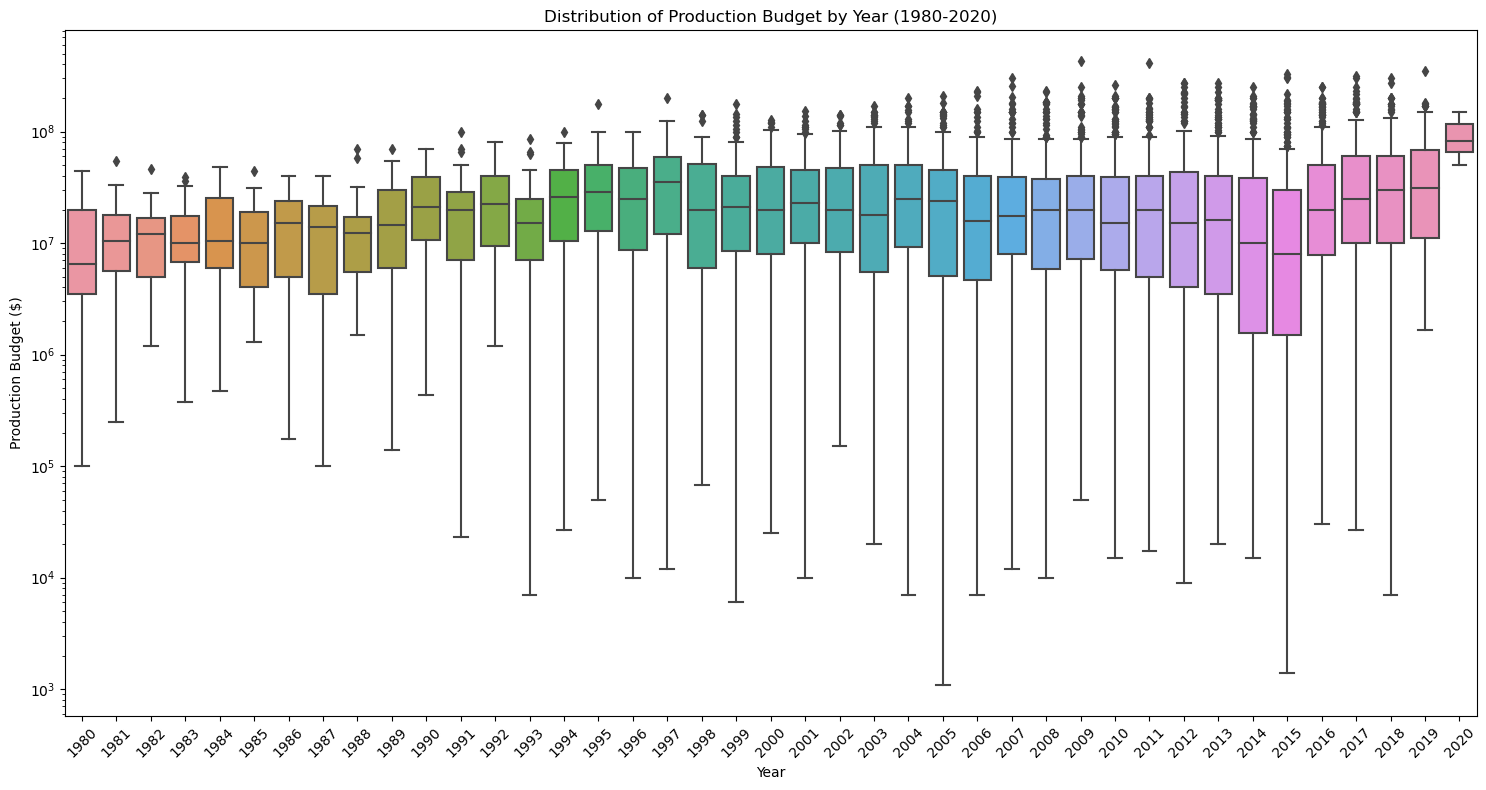

In [46]:
# Ensure the year and production_budget are in the correct format
movie_budgets_df['year'] = pd.to_datetime(movie_budgets_df['release_date'], errors='coerce').dt.year
movie_budgets_df['production_budget'] = pd.to_numeric(movie_budgets_df['production_budget'], errors='coerce')

# Filter the dataframe for years 1980-2020
filtered_df = movie_budgets_df[(movie_budgets_df['year'] >= 1980) & (movie_budgets_df['year'] <= 2020)]

# Create the plot
plt.figure(figsize=(15, 8))
sns.boxplot(x='year', y='production_budget', data=filtered_df)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Production Budget ($)')
plt.title('Distribution of Production Budget by Year (1980-2020)')

# Use log scale for y-axis due to wide range of budget values
plt.yscale('log')

# Show the plot
plt.tight_layout()
plt.show()

#### Merged_df

In [47]:
#
merged_df.describe()

,id,runtime,standardized_rating
count,39453.000000,39453.000000,39453.000000
mean,1033.712721,110.136091,6.372296
std,581.397463,21.180028,1.919961
min,3.000000,52.000000,0.000000
25%,539.000000,96.000000,6.000000
50%,1067.000000,108.000000,6.387382
75%,1525.000000,119.000000,7.500000
max,2000.000000,358.000000,12.500000


In [48]:
#checking correlation between run time and standardized_rating
merged_df[['runtime','standardized_rating']].corr()

,runtime,standardized_rating
runtime,1.000000,0.150805
standardized_rating,0.150805,1.000000


A weak correlation
0.17 indicates a weak positive correlation between runtime and critic ratings.
This means that as movie runtime increases, there's a slight tendency for critic ratings to increase as well, but the relationship is not strong.
Runtime is not a major factor in viewer's ratings.

In [49]:
# Count occurrences of each genre
genre_counts = merged_df['genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Calculate mean standardized rating for each genre
genre_ratings = merged_df.groupby('genre')['standardized_rating'].mean().reset_index()
genre_ratings.columns = ['genre', 'mean_standardized_rating']

# Merge genre counts and mean standardized ratings
genre_summary = pd.merge(genre_counts, genre_ratings, on='genre')

# Count occurrences of each MPAA rating
mpaa_counts = merged_df['MPAA_rating'].value_counts().reset_index()
mpaa_counts.columns = ['MPAA_rating', 'count']

# Calculate average runtime for each MPAA rating
mpaa_runtime = merged_df.groupby('MPAA_rating')['runtime'].mean().reset_index()
mpaa_runtime.columns = ['MPAA_rating', 'average_runtime']

# Merge MPAA counts and average runtimes
mpaa_summary = pd.merge(mpaa_counts, mpaa_runtime, on='MPAA_rating')

print("Genre Summary:")
print(genre_summary)
print("\nMPAA Rating Summary:")
print(mpaa_summary)

Genre Summary:
                                                 genre  count  \
0                                                Drama   5563   
1                                               Comedy   3140   
2                                         Comedy|Drama   3004   
3                           Drama|Mystery and Suspense   2161   
4                                 Comedy|Drama|Romance   1354   
..                                                 ...    ...   
233                                   Classics|Western      1   
234                                            Western      1   
235  Art House and International|Drama|Mystery and ...      1   
236                            Comedy|Drama|Television      1   
237                  Comedy|Kids and Family|Television      1   

     mean_standardized_rating  
0                    6.662815  
1                    5.546162  
2                    6.742388  
3                    6.471067  
4                    6.497225  
..          

##### Profit vs Month

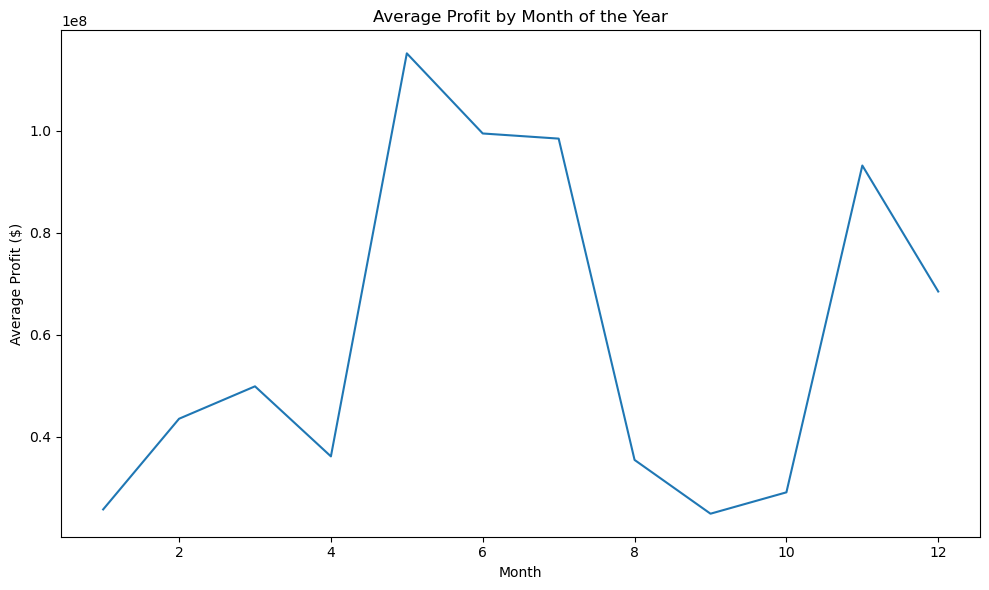

In [52]:
# Extract the month from the release_date column
movie_budgets_df['month'] = pd.to_datetime(movie_budgets_df['release_date'], errors='coerce').dt.month

# Calculate the profit for each movie
movie_budgets_df['profit'] = movie_budgets_df['worldwide_gross'] - movie_budgets_df['production_budget']

# Calculate the average profit by month
monthly_avg_profit = movie_budgets_df.groupby('month')['profit'].mean()

# Create the line graph
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_avg_profit.index, y=monthly_avg_profit.values)

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Average Profit ($)')
plt.title('Average Profit by Month of the Year')

# Show the plot
plt.tight_layout()
plt.show()

In [41]:
# Group by director and calculate mean standardized rating and count of movies
director_stats = merged_df.groupby('director').agg({
    'standardized_rating': 'mean',
    'id': 'count'  # Assuming 'id' is unique for each movie
}).rename(columns={'id': 'movie_count'})

# Sort by mean rating in descending order
director_stats_sorted = director_stats.sort_values('standardized_rating', ascending= False)

# Display the top directors (you can adjust the number as needed)
print(director_stats_sorted.head(20))

                       standardized_rating  movie_count
director                                               
Cheryl Dunye                      9.000000            1
Eric Rohmer                       8.820820            9
Yasujiro Ozu                      8.791920           31
Alexander Mackendrick             8.416246           43
Sam Peckinpah                     8.282307           29
Blake Edwards                     8.277476            5
William Wyler                     8.251905           13
Alain Tanner                      8.193691            2
Preston Sturges                   8.166135           17
Irving Rapper                     8.149399           21
Marco Tullio Giordana             8.144313           53
Frank Capra                       8.140292           62
Ingmar Bergman                    8.132031           53
Jae-young Kwak                    8.125000            2
Amy Berg                          8.118836           55
Joel Coen|Ethan Coen              8.105343      

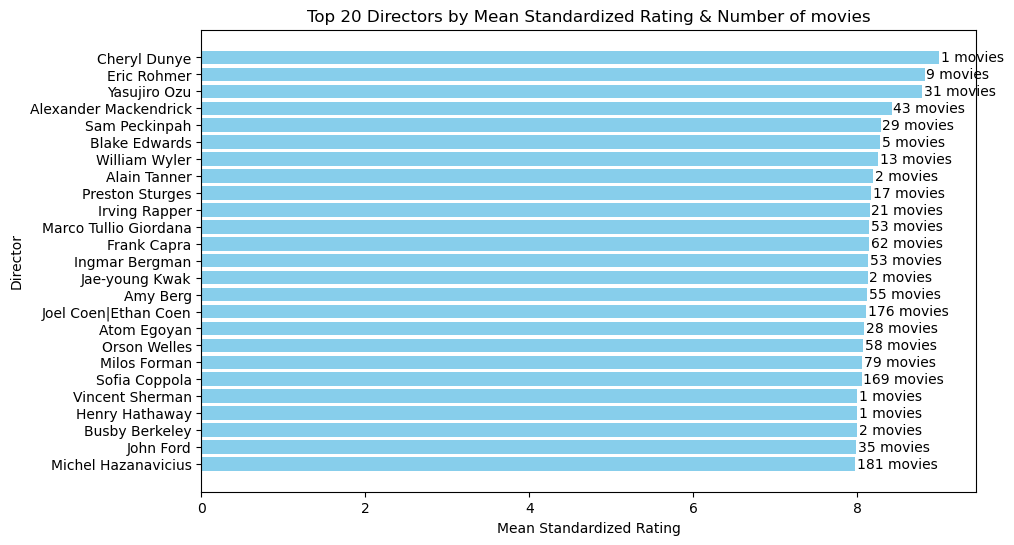

In [42]:
# Take the top 20 directors
top_directors = director_stats_sorted.head(25)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_directors.index, top_directors['standardized_rating'], color='skyblue')
plt.xlabel('Mean Standardized Rating')
plt.ylabel('Director')
plt.title('Top 20 Directors by Mean Standardized Rating & Number of movies')
plt.gca().invert_yaxis()  # To display the director with the highest rating at the top

# Add text labels for 'movie_count' to each bar
for i, bar in enumerate(plt.gca().patches):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"{top_directors['movie_count'].iloc[i]} movies",
             va='center')

plt.show()

In [45]:
movie_budgets_df.describe()

,id,release_date,production_budget,domestic_gross,worldwide_gross
count,5782.000000,5782,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,2004-07-06 05:20:31.546177792,3.158776e+07,4.187333e+07,9.148746e+07
min,1.000000,1915-02-08 00:00:00,1.100000e+03,0.000000e+00,0.000000e+00
25%,25.000000,2000-04-22 18:00:00,5.000000e+06,1.429534e+06,4.125415e+06
50%,50.000000,2007-03-02 00:00:00,1.700000e+07,1.722594e+07,2.798445e+07
75%,75.000000,2012-12-25 00:00:00,4.000000e+07,5.234866e+07,9.764584e+07
max,100.000000,2020-12-31 00:00:00,4.250000e+08,9.366622e+08,2.776345e+09
std,28.821076,NaN,4.181208e+07,6.824060e+07,1.747200e+08


In [43]:
#Finding correlation between the production cost and gross earnings(domestic and worldwide)
movie_budgets_df[['production_budget','domestic_gross','worldwide_gross']].corr()

,production_budget,domestic_gross,worldwide_gross
production_budget,1.000000,0.685682,0.748306
domestic_gross,0.685682,1.000000,0.938853
worldwide_gross,0.748306,0.938853,1.000000


#### Correlation Analysis:

1. Production Budget vs Domestic Gross: 0.686
   - Moderately strong positive correlation
   - Higher budgets tend to yield higher domestic earnings

2. Production Budget vs Worldwide Gross: 0.748
   - Stronger positive correlation than domestic
   - Big budgets have more impact on global earnings

3. Domestic Gross vs Worldwide Gross: 0.939
   - Very strong positive correlation
   - Domestic success strongly indicates global success

Key Insights from this analysis:

1. Budget Impact: Higher budgets are associated with higher earnings, both domestically and worldwide. The stronger correlation with worldwide gross suggests that big-budget movies might have more international appeal or marketing reach.
2. Domestic performance is a good predictor of global performance. Domestic-Worldwide relationship: The very strong correlation between domestic and worldwide gross implies that domestic performance is a good indicator of global performance. This could be due to factors like marketing strategies that work well across markets or the global influence of the US film market.
3. Budget isn't the only factor; While there's a positive correlation between budget and earnings, it's not perfect. This suggests that other factors (like quality, marketing, timing, etc.) play significant roles in a movie's financial success.
4. Worldwide potential: The stronger correlation between budget and worldwide gross (compared to domestic gross) might indicate that higher budgets are particularly beneficial for international appeal, perhaps due to more spectacular visual effects, bigger stars, or larger marketing campaigns that resonate globally.

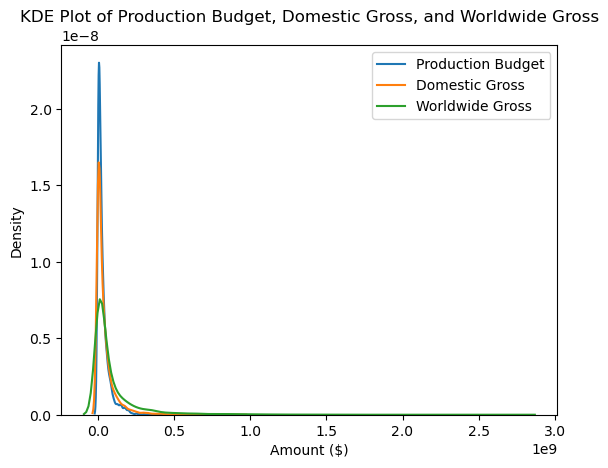

In [44]:
# kde plot of 'production_budget', 'domestic_gross', 'worldwide_gross'
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the KDE for each column
sns.kdeplot(data=movie_budgets_df, x='production_budget', ax=ax, label='Production Budget')
sns.kdeplot(data=movie_budgets_df, x='domestic_gross', ax=ax, label='Domestic Gross')
sns.kdeplot(data=movie_budgets_df, x='worldwide_gross', ax=ax, label='Worldwide Gross')

# Set the title and labels
ax.set_title('KDE Plot of Production Budget, Domestic Gross, and Worldwide Gross')
ax.set_xlabel('Amount ($)')
ax.set_ylabel('Density')

# Show the legend
ax.legend()

# Show the plot
plt.show()

# Conclusions and Recommendations
##### 1.Best Movies Genre for Production
Conclusion:

Drama: The genre with the highest occurrence and a significant mean standardized rating. This suggests that drama movies are both frequently produced and generally well-received.
Comedy: Another frequently occurring genre, but with a slightly lower mean standardized rating compared to drama. Comedy is also a popular genre for production.
Mixed Genres: Movies that combine genres, such as Comedy|Drama, have high occurrences and good ratings, indicating a successful formula.

* Drama: Based on our data it is highly evident that the drama category is the most popular among viewers with a significantly high number of occurences ie `28394` and a high mean standard rating ie `6.663` compared to the 2nd most popular category, comedy with a occurence `15514` and mean of `5.546` meaning drama category is more appealing and engaging to a higher audience. 

* Mixed Genres: in Movies that combine genres, it is evident that the combination for  Comedy & Drama, have high a high occurrence of `5358` and rating of `6.742` indicating a successful formula/combination. This shows that movies that blend elements of both comedy and drama are more apealing to a lerger audience. These film offer the best of both worlds providing viewers with a balanced mix of humor and eotional depth.
* It is noted that the average production budget for the movies over the years is `$ 31 million` with an average domestic and world_wide revenue of `$ 41 million` and `$ 91 million` respectively.

##### 2. Average Production Budget

* There is a moderately strong positive correlation between production budget and domestic gross at `0.686.`
* There is a strong positive correlation between prodction budget and worl-wide gross at `0.748`, implying that high budgets have more impact on global earnings, which may reflect in quality directors, advertisemnts, actors.
* There is also a very strong positive correlation between domestic gross and worldwide gross at `0.939`, implying that if a movie succeeds domestically, it will succeed globally.

##### 3.Movie Length
* From the Findings, there is a very low positive correlation of `0.15` between movie length and the critic-rating, implying that as the movie runtime increases, there is slight tendency for critic rating to increase as well but the relationship is not strong.

##### 4.Recomended Director to Hire
* The Coen brothers ie Joen Coen and Ethan Coen have directed `176 movies` with a rating of `8.105.` This indicates that they are highly respected film makers with a strong track record of producing quality films. 
* The next recommended director is Sofia Coppola  whose movies have a rating of `8.052129` having directed `169 movies`. Her high average rating is essentionally high which suggests that her movies are consistently well received by critics and audiences alike.

##### 5. Release Date
* Based on the analysis of the average profit by month of the year, it is evident that May, June, and July are the most profitable months for movies. May has an average profit of `11.5 million` followed closely by June with `10 million` and July with `9.8 million`. This could be due to a variety of factors, such as the release of popular blockbusters during these months, favorable weather conditions, or the end of the school year leading to increased attendance.
Therefore, we should consider releasing movies during one of these three months to bolster profitability.
